# Deep Learning: Ex.9 - GAN

Submitted by: Noam Bassat 308465434


In [57]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # optional: "taqaddum" progress-bar

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

print(tf.__version__)

2.4.1


***

### 1. Training a GAN model using the MNIST dataset

- Use our code from `class9.ipynb` to train a GAN model using the MNIST dataset, for 20 epochs.

- Use a latent dimension of 20-D as the noise input for the generator model.

- Generate 16 noise vectors (each one is of 20-D), and use these vectors to generate 16 images from the generator, after each training epoch (like we did in class).

- After the 20 epochs, generate (and display) 64 new images from the generator.

In [58]:
# Create the discriminator
D_model = Sequential(name='Discriminator')
D_model.add(Input(shape=(28,28,1))) # to match the MNIST dataset 

D_model.add(Conv2D(32, (4,4), strides=(2, 2), padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
# D_model.add(Dropout(0.4))

D_model.add(Conv2D(64, (4,4), strides=(2, 2), padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
# D_model.add(Dropout(0.4))


D_model.add(Conv2D(128, (4,4), strides=(2, 2), padding='same'))
D_model.add(LeakyReLU(alpha=0.2))

D_model.add(Flatten())
D_model.add(Dense(1, activation='sigmoid'))


# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
D_model.compile(loss='binary_crossentropy', optimizer=opt)

D_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 14, 14, 32)        544       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          32832     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 128)         131200    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)            

In [59]:
# Create the generator

latent_dim = 20 # dimension of the noise seed 

G_model = Sequential(name='G_model')
G_model.add(Dense(128*7*7, input_dim=latent_dim)) 
G_model.add(LeakyReLU(alpha=0.2))
G_model.add(Reshape((7, 7, 128)))

# upsample to 14x14
G_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))

# upsample to 28x28
G_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))

G_model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

G_model.summary()

Model: "G_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 6272)              131712    
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 28, 28, 128)       0   

In [60]:
# first, make weights in the discriminator not trainable
D_model.trainable = False

# then connect the models:
GAN_model = Sequential(name='GAN_model')
GAN_model.add(G_model) # add the generator
GAN_model.add(D_model) # add the discriminator

# lastly, compile the GAN model:
opt = Adam(lr=0.0002, beta_1=0.5)
GAN_model.compile(loss='binary_crossentropy', optimizer=opt)

GAN_model.summary()

Model: "GAN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
G_model (Sequential)         (None, 28, 28, 1)         662529    
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 166625    
Total params: 829,154
Trainable params: 662,529
Non-trainable params: 166,625
_________________________________________________________________


In [61]:
# load the MNIST dataset
from keras.datasets import mnist

(trainX, trainY), _ = mnist.load_data()
dataset = trainX[...,None]
dataset = dataset.astype('float32')
dataset = dataset / 255.0  #  rescale: [0,255] to [0.0,1.0]

print('dataset.shape =',dataset.shape)

dataset.shape = (60000, 28, 28, 1)


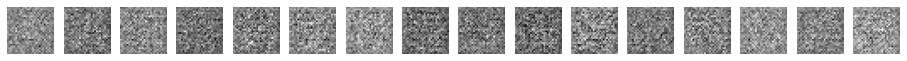

(16, 20)

In [62]:
# lets generate some examples, to visualize training progress..
n_examples = 16
examples_input = np.random.randn(n_examples,latent_dim)
examples = G_model.predict(examples_input)
plt.figure(figsize=(n_examples,1))
for i in range(n_examples):
    plt.subplot(1, n_examples, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap='gray')
plt.show()
examples_input.shape



  0%|          | 0/20 [00:00<?, ?it/s]

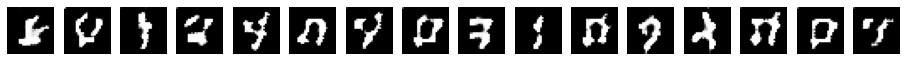



  5%|▌         | 1/20 [01:09<22:03, 69.64s/it]

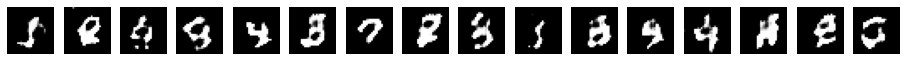



 10%|█         | 2/20 [02:17<20:46, 69.25s/it]

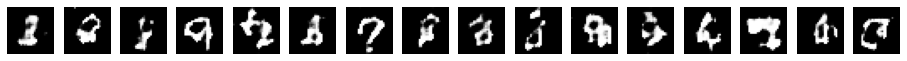



 15%|█▌        | 3/20 [03:27<19:36, 69.23s/it]

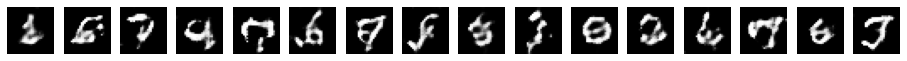



 20%|██        | 4/20 [04:36<18:27, 69.23s/it]

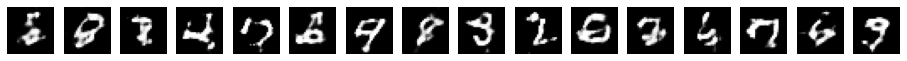



 25%|██▌       | 5/20 [05:44<17:14, 68.94s/it]

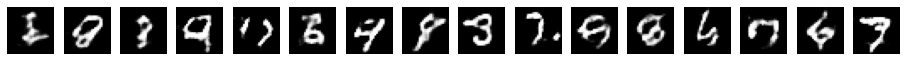



 30%|███       | 6/20 [06:53<16:04, 68.92s/it]

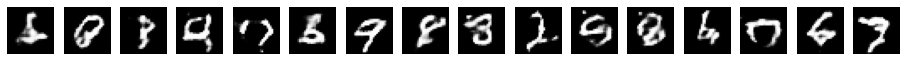



 35%|███▌      | 7/20 [08:03<14:58, 69.14s/it]

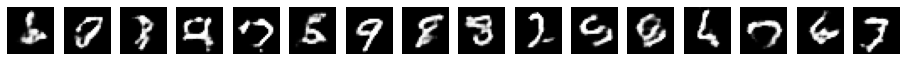



 40%|████      | 8/20 [09:13<13:52, 69.34s/it]

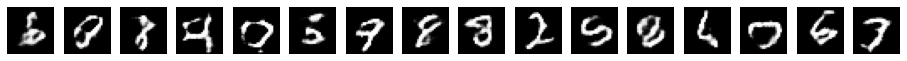



 45%|████▌     | 9/20 [10:22<12:42, 69.28s/it]

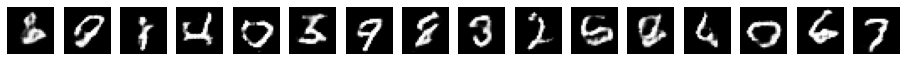



 50%|█████     | 10/20 [11:31<11:33, 69.40s/it]

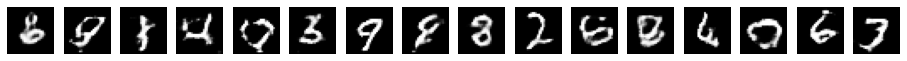



 55%|█████▌    | 11/20 [12:41<10:24, 69.39s/it]

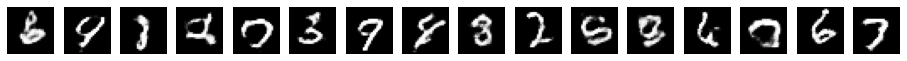



 60%|██████    | 12/20 [13:50<09:15, 69.38s/it]

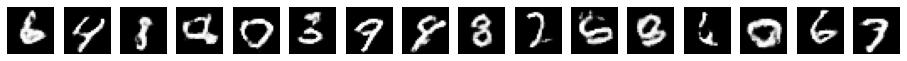



 65%|██████▌   | 13/20 [15:00<08:05, 69.41s/it]

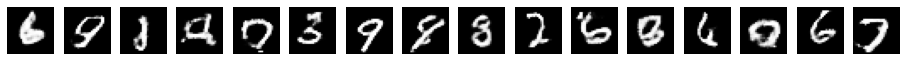



 70%|███████   | 14/20 [16:09<06:56, 69.48s/it]

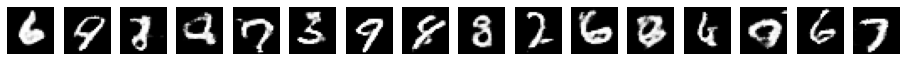



 75%|███████▌  | 15/20 [17:18<05:47, 69.42s/it]

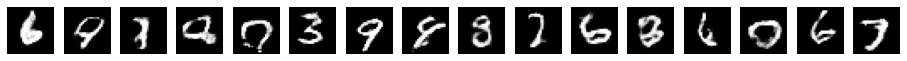



 80%|████████  | 16/20 [18:28<04:37, 69.44s/it]

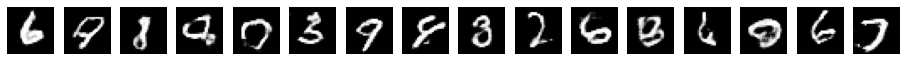



 85%|████████▌ | 17/20 [19:38<03:28, 69.48s/it]

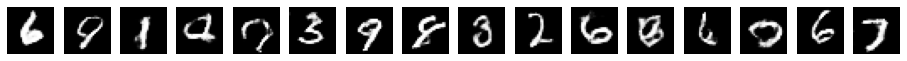



 90%|█████████ | 18/20 [20:47<02:19, 69.52s/it]

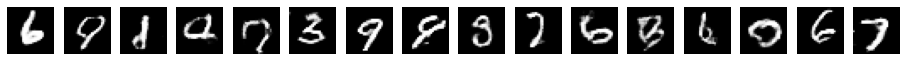



 95%|█████████▌| 19/20 [21:56<01:09, 69.41s/it]

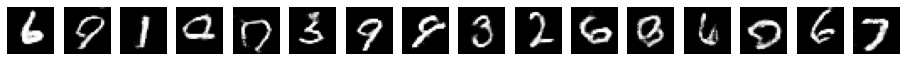



100%|██████████| 20/20 [23:06<00:00, 69.34s/it]


In [63]:
n_batch = 128
n_epochs = 20
batch_per_epoch = dataset.shape[0] // n_batch


for i in tqdm(range(n_epochs)):
  for j in range(batch_per_epoch):

    # generate 'real' samples
    ix = np.random.randint(0, dataset.shape[0], n_batch)     
    X_real = dataset[ix] # choose random instances
    y_real = np.ones((n_batch, 1)) # 'real' class labels = 1

    # generate 'fake' examples
    noise_input = np.random.randn(n_batch,latent_dim)
    X_fake = G_model.predict(noise_input)
    y_fake = np.zeros((n_batch, 1))  # 'fake' class labels = 0

    # update discriminator model weights
    D_loss_real = D_model.train_on_batch(X_real, y_real)
    D_loss_fake = D_model.train_on_batch(X_fake, y_fake)
    D_loss = (D_loss_real+D_loss_fake) / 2

    # prepare points in latent space as input for the generator
    X_gan = np.random.randn(n_batch,latent_dim)
    y_gan = np.ones((n_batch, 1)) #  labels = 1 (wants discriminator to mistake images as real..)
   
    # update the generator via the discriminator's error
    G_loss = GAN_model.train_on_batch(X_gan, y_gan)

  # summarize loss on this batch
  examples1 = G_model.predict(examples_input)
  plt.figure(figsize=(n_examples,1))
  for i in range(n_examples):
      plt.subplot(1, n_examples, 1 + i)
      plt.axis('off')
      plt.imshow(examples1[i, :, :, 0], cmap='gray')
  plt.show()



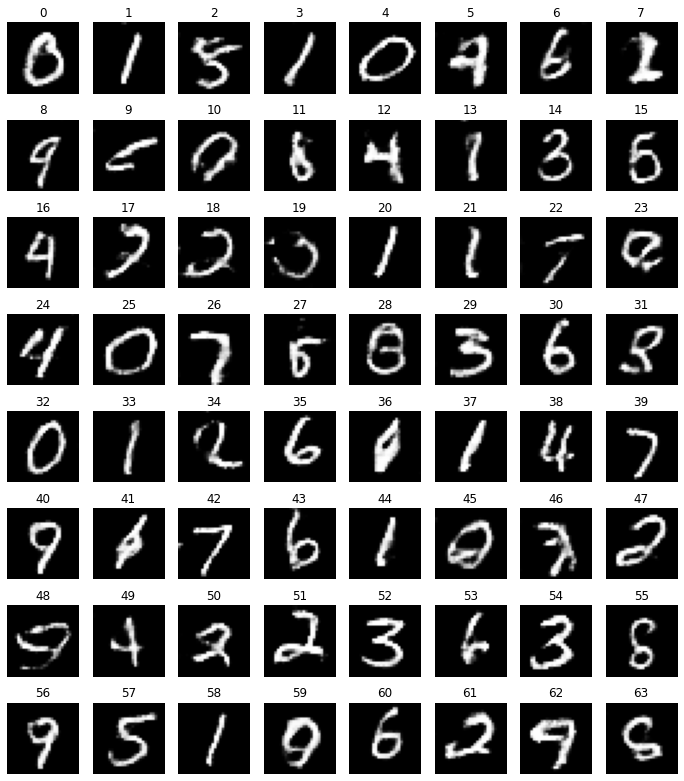

In [64]:
# generate some 'fake' examples
n = 64
noise_input = np.random.randn(n,latent_dim)
examples2 = G_model.predict(noise_input)

plt.figure(figsize=(12,14))
for i in range(n):
    plt.subplot(8, 8, 1 + i)
    plt.axis('off')
    plt.imshow(examples2[i, :, :, 0], cmap='gray')
    plt.title(i)

***

### 2. Exploring the latent (input) space

- Out of the 64 noise-vectors you generates, pick one that generated a nice output image. Denote this noise-vector as `Z`.

- Generate 64 new input vectors, based on this specific `Z`, in the following way:

We will add a small-variance noise (a.k.a pertubation, also of 20-D) to `Z`, and feed the new vector (`Z`+pertubation) to the generator, to generate a new image.

Repeat this process to generate a total of 64 new images (each generated from the same `Z` but with a different pertubation).

- Display the results.

(Use a Normal distribution with $\sigma=0.2$ for the pertubations)



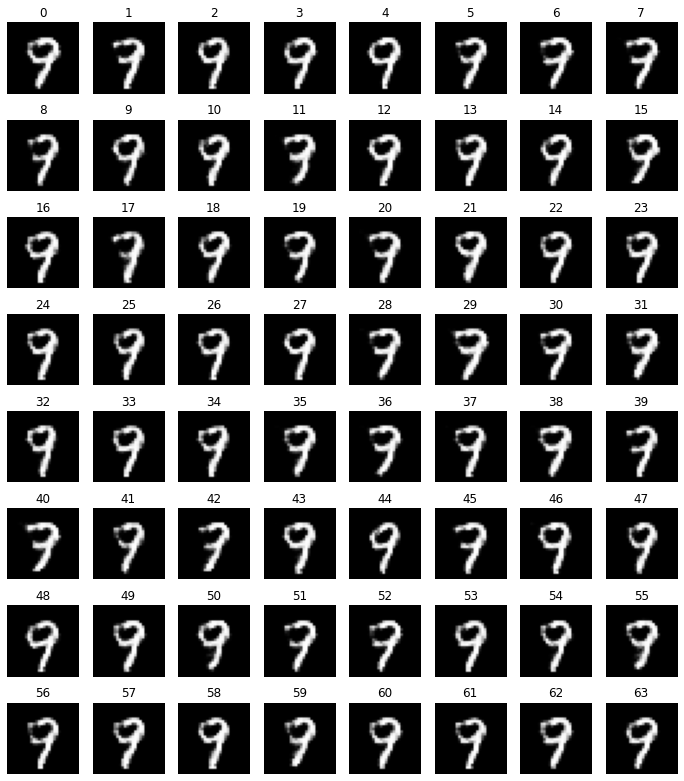

In [65]:
n = 64
Z =noise_input[56]

plt.figure(figsize=(12,14))
for i in range(n):
  Z_input = np.zeros((n,latent_dim))
  Z_input  += np.random.normal(Z,0.2)

  examples3 = G_model.predict(Z_input)

  plt.subplot(8, 8, 1 + i)
  plt.axis('off')
  plt.imshow(examples3[i, :, :, 0], cmap='gray')
  plt.title(i)



***
### 3. Morphing between two images


- Pick 2 out of the 64 examples you've generated in Q1.

- We will try to "morph" between these two images, by "walking" in the latent space from `Z_1` (the latent vector of the 1st image) and `Z_2` (the latent vector of the 2nd image):

Generate a set of 10 input-vectors, using a linear interpolation:

$$ Z_{interp} \ \ =\ \  \alpha \cdot Z_1 \ \ +\ \  (1-\alpha) \cdot Z_2$$

by varying $\alpha$ from 0 to 1.

- Use this interpolated input vectors to generate a sequence of new images, using the generator.

- Display the results.



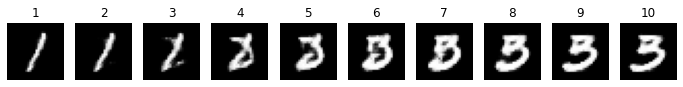

In [70]:
Z1 = noise_input[32]
Z2 = noise_input[56]
n = 64
ALPHA = 0.0
plt.figure(figsize=(12,14))
for i in range(10):
    Z_inerp = np.zeros((n,latent_dim))
    Z_inerp  += Z1*ALPHA + (1-ALPHA)*Z2
    examples4 = G_model.predict(Z_inerp)
    ALPHA += 0.1
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(examples4[i, :, :, 0], cmap='gray')
    plt.title(i+1)


***
### 4. Train a GAN using a faces dataset.

In this last question, we will use a small subset of the CelebA faces dataset to train a small GAN (it's highly recommended to use Google Colab for this part).

We will resize the faces images to a small form factor, of size `(32,32,3)`.

- Adjust the architecture of your network accordingly (to match the images shape).

- Train the GAN for 10-20 epochs and display the result (as you did in Q1).



In [71]:
# download the dataset, and unzip it.
# if you are running on your local computer, just get the zip file directly from the URL bellow
# if you are running on Google Colab, use the following code to do that:

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"


import os
import gdown
from zipfile import ZipFile

os.makedirs("dataset",exist_ok=True)
output = "dataset/data.zip"
gdown.download(url, output, quiet=False)  # ~1.4GB zip file (over 200,000 faces images)

print('unzipping...')

with ZipFile("dataset/data.zip", "r") as zipobj:
    zipobj.extractall("dataset")  # unzip the file
    
print('done !')

Downloading...
From: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
To: /content/dataset/data.zip


0.00B [00:00, ?B/s]

4.72MB [00:00, 34.8MB/s]

30.9MB [00:00, 47.1MB/s]

57.7MB [00:00, 62.5MB/s]

82.8MB [00:00, 80.6MB/s]

102MB [00:00, 96.9MB/s] 

120MB [00:00, 98.7MB/s]

140MB [00:00, 117MB/s] 

157MB [00:01, 90.5MB/s]

177MB [00:01, 105MB/s] 

193MB [00:01, 94.2MB/s]

220MB [00:01, 117MB/s] 

237MB [00:01, 113MB/s]

256MB [00:01, 128MB/s]

277MB [00:01, 144MB/s]

298MB [00:02, 158MB/s]

316MB [00:02, 120MB/s]

339MB [00:02, 140MB/s]

364MB [00:02, 161MB/s]

384MB [00:02, 137MB/s]

402MB [00:02, 147MB/s]

420MB [00:02, 153MB/s]

441MB [00:02, 167MB/s]

463MB [00:03, 179MB/s]

482MB [00:03, 183MB/s]

502MB [00:03, 165MB/s]

520MB [00:03, 164MB/s]

540MB [00:03, 174MB/s]

559MB [00:03, 178MB/s]

583MB [00:03, 192MB/s]

605MB [00:03, 200MB/s]

626MB [00:03, 168MB/s]

644MB [00:04, 170MB/s]

663MB [00:04, 173MB/s]

688MB [00:04, 191MB/s]

708MB [00:04, 151MB/s]

726MB

unzipping...
done !


In [72]:
# we will use a set of 100,000 images from this dataset:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataGen = ImageDataGenerator(rescale=1./255)

dataset = dataGen.flow_from_directory('dataset', target_size=(32,32), batch_size=100000, class_mode='sparse').next()[0]

dataset.shape

Found 202599 images belonging to 1 classes.


(100000, 32, 32, 3)

In [73]:
# Create the discriminator
D_model = Sequential(name='Discriminator')
D_model.add(Input(shape=(32,32,3))) # to match the MNIST dataset 

D_model.add(Conv2D(32, (4,4), strides=(2, 2), padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
# D_model.add(Dropout(0.4))

D_model.add(Conv2D(64, (4,4), strides=(2, 2), padding='same'))
D_model.add(LeakyReLU(alpha=0.2))
# D_model.add(Dropout(0.4))


D_model.add(Conv2D(128, (4,4), strides=(2, 2), padding='same'))
D_model.add(LeakyReLU(alpha=0.2))

D_model.add(Flatten())
D_model.add(Dense(1, activation='sigmoid'))


opt = Adam(lr=0.0002, beta_1=0.5)
D_model.compile(loss='binary_crossentropy', optimizer=opt)
# Create the generator


D_model.summary()


Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 16, 16, 32)        1568      
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 64)          32832     
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 128)         131200    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)            

In [74]:
latent_dim = 20 # dimension of the noise seed 

G_model = Sequential(name='G_model')
G_model.add(Dense(128*8*8, input_dim=latent_dim)) 
G_model.add(LeakyReLU(alpha=0.2))
G_model.add(Reshape((8, 8, 128)))

# upsample to 14x14
G_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))

# upsample to 28x28
G_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
G_model.add(LeakyReLU(alpha=0.2))

G_model.add(Conv2D(3, (7,7), activation='sigmoid', padding='same'))

# first, make weights in the discriminator not trainable
D_model.trainable = False

G_model.summary()

Model: "G_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 8192)              172032    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 32, 32, 128)       0   

In [75]:
# then connect the models:
GAN_model = Sequential(name='GAN_model')
GAN_model.add(G_model) # add the generator
GAN_model.add(D_model) # add the discriminator

# lastly, compile the GAN model:
opt = Adam(lr=0.0002, beta_1=0.5)
GAN_model.compile(loss='binary_crossentropy', optimizer=opt)

GAN_model.summary()

Model: "GAN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
G_model (Sequential)         (None, 32, 32, 3)         715395    
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 167649    
Total params: 883,044
Trainable params: 715,395
Non-trainable params: 167,649
_________________________________________________________________




  0%|          | 0/20 [00:00<?, ?it/s]

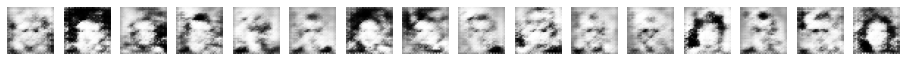



  5%|▌         | 1/20 [02:32<48:11, 152.18s/it]

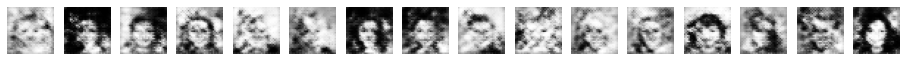



 10%|█         | 2/20 [05:03<45:32, 151.83s/it]

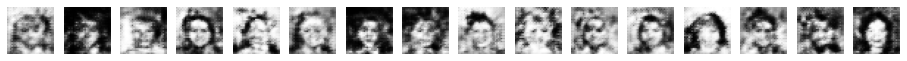



 15%|█▌        | 3/20 [07:34<42:56, 151.56s/it]

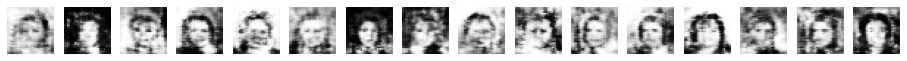



 20%|██        | 4/20 [10:05<40:24, 151.55s/it]

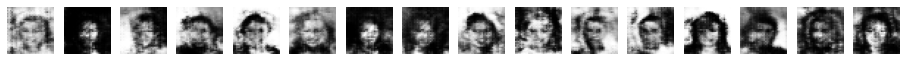



 25%|██▌       | 5/20 [12:36<37:51, 151.46s/it]

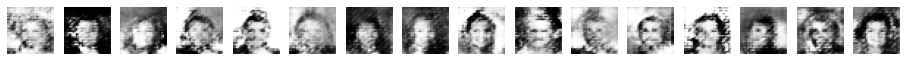



 30%|███       | 6/20 [15:07<35:17, 151.22s/it]

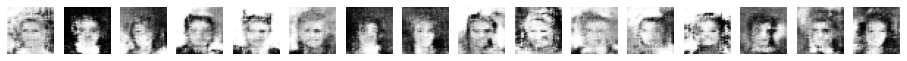



 35%|███▌      | 7/20 [17:38<32:45, 151.17s/it]

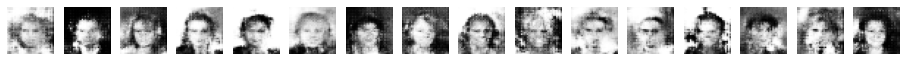



 40%|████      | 8/20 [20:09<30:12, 151.03s/it]

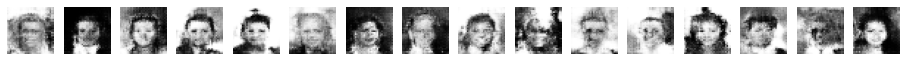



 45%|████▌     | 9/20 [22:40<27:41, 151.01s/it]

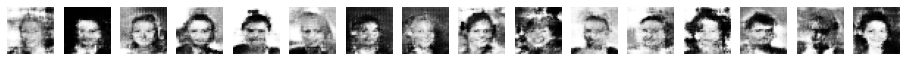



 50%|█████     | 10/20 [25:11<25:09, 150.94s/it]

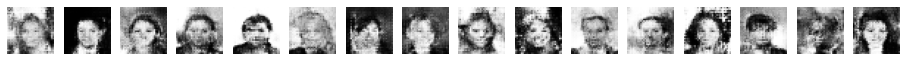



 55%|█████▌    | 11/20 [27:41<22:37, 150.81s/it]

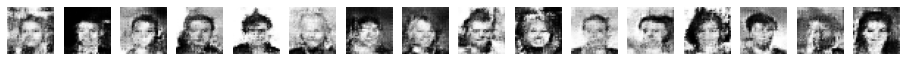



 60%|██████    | 12/20 [30:12<20:06, 150.76s/it]

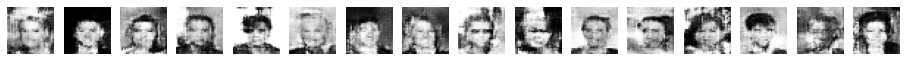



 65%|██████▌   | 13/20 [32:42<17:35, 150.76s/it]

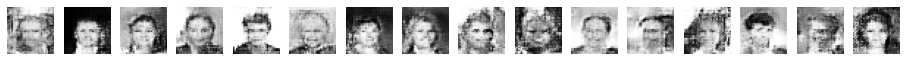



 70%|███████   | 14/20 [35:13<15:04, 150.79s/it]

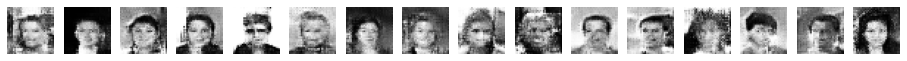



 75%|███████▌  | 15/20 [37:44<12:33, 150.75s/it]

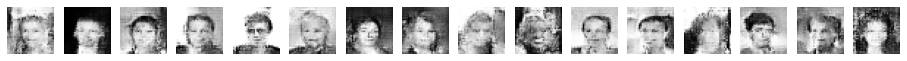



 80%|████████  | 16/20 [40:15<10:02, 150.74s/it]

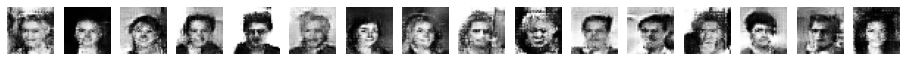



 85%|████████▌ | 17/20 [42:45<07:32, 150.71s/it]

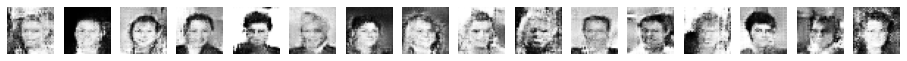



 90%|█████████ | 18/20 [45:16<05:01, 150.80s/it]

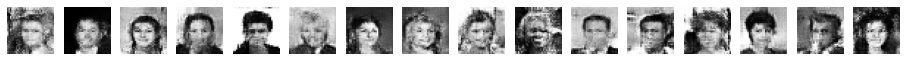



 95%|█████████▌| 19/20 [47:47<02:30, 150.79s/it]

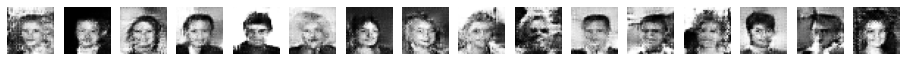



100%|██████████| 20/20 [50:18<00:00, 150.90s/it]


In [76]:
n_batch = 128
n_epochs = 20
batch_per_epoch = dataset.shape[0] // n_batch
for i in tqdm(range(n_epochs)):
  for j in range(batch_per_epoch):

    # generate 'real' samples
    ix = np.random.randint(0, dataset.shape[0], n_batch)     
    X_real = dataset[ix] # choose random instances
    y_real = np.ones((n_batch, 1)) # 'real' class labels = 1

    # generate 'fake' examples
    noise_input = np.random.randn(n_batch,latent_dim)
    X_fake = G_model.predict(noise_input)
    y_fake = np.zeros((n_batch, 1))  # 'fake' class labels = 0

    # update discriminator model weights
    D_loss_real = D_model.train_on_batch(X_real, y_real)
    D_loss_fake = D_model.train_on_batch(X_fake, y_fake)
    D_loss = (D_loss_real+D_loss_fake) / 2

    # prepare points in latent space as input for the generator
    X_gan = np.random.randn(n_batch,latent_dim)
    y_gan = np.ones((n_batch, 1)) #  labels = 1 (wants discriminator to mistake images as real..)
   
    # update the generator via the discriminator's error
    G_loss = GAN_model.train_on_batch(X_gan, y_gan)

  # summarize loss on this batch
  examples1 = G_model.predict(examples_input)
  plt.figure(figsize=(n_examples,1))
  for i in range(n_examples):
      plt.subplot(1, n_examples, 1 + i)
      plt.axis('off')
      plt.imshow(examples1[i, :, :, 0], cmap='gray')
  plt.show()


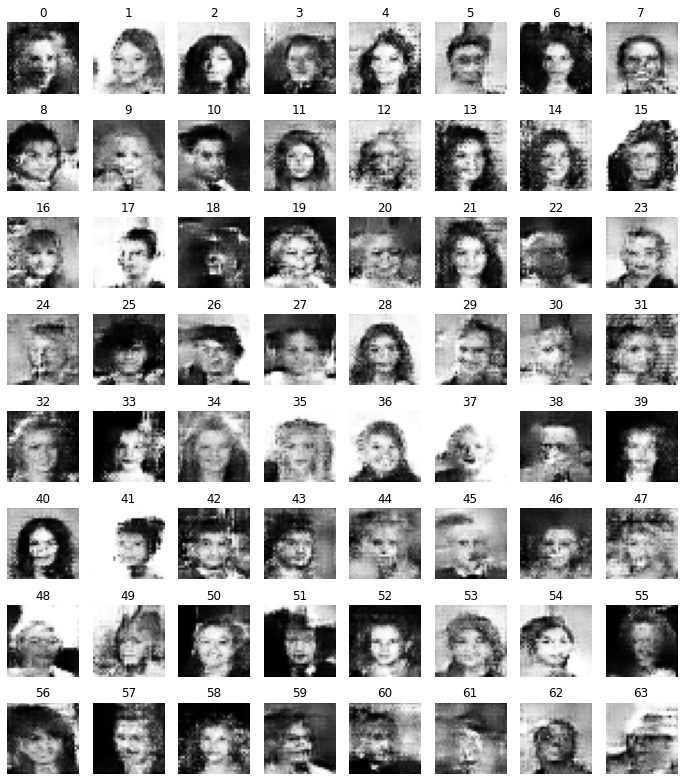

In [77]:
n = 64
noise_input = np.random.randn(n,latent_dim)
examples = G_model.predict(noise_input)

plt.figure(figsize=(12,14))
for i in range(n):
    plt.subplot(8, 8, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap='gray')
    plt.title(i)

***
## Good Luck!